In [1]:
import pandas as pd
import numpy as np
import zipfile
import plotly.express as px
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch

import sys
sys.path.append('../code/')


from data.dataset import TileDataset, PredictFromImgDataset
from data.transforms import HE_preprocess
from model_zoo.models import define_model
from utils.metrics import dice_scores_img
from utils.plots import plot_global_pred, plot_thresh_scores
from training.predict import predict_entire_mask

%load_ext autoreload
%autoreload 2

In [2]:
tile_size = 256   #the size of tiles
reduce_fac = 4 #reduce the original images by 4 times 
MASKS = '../input/hubmap-kidney-segmentation/train.csv'
DATA = '../input/hubmap-kidney-segmentation/train/'
ZIP_TRAIN = f'../input/hubmap-kidney-segmentation/train_{tile_size}_red_{reduce_fac}.zip'
ZIP_MASKS = f'../input/hubmap-kidney-segmentation/masks_{tile_size}_red_{reduce_fac}.zip'

IMG_FOLDER = f'../input/hubmap-kidney-segmentation/train_{tile_size}_red_{reduce_fac}/'
MSK_FOLDER = f'../input/hubmap-kidney-segmentation/masks_{tile_size}_red_{reduce_fac}/'

INFO = '../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv'
df_info = pd.read_csv(INFO)

In [3]:
df_mask = pd.read_csv(MASKS)
slide_ids = df_mask.id.unique().tolist()

with zipfile.ZipFile(ZIP_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(ZIP_MASKS, 'r') as msk_arch:
    fnames = img_arch.namelist()
    
df_images = pd.DataFrame()
df_images['tile_name'] = fnames
df_images['fold'] = df_images['tile_name'].apply(lambda f: slide_ids.index(f.split("_", 1)[0]))

# Predict on whole slide

In [4]:
# Load pretrained models
encoder = "resnet34"
decoder = "Unet"
tile_size = 256   #the size of tiles
reduce_fac = 4 #reduce the original images by 4 times


In [5]:


# for fold_nb in range(8)[::-1]:
#     model = define_model(decoder, encoder, num_classes=1, activation=None, pretrained=None).to("cuda")
#     model_name = f"{encoder}_{decoder}_{tile_size}_{reduce_fac}_fold{fold_nb}"
#     model.load_state_dict(torch.load(f"../models/{model_name}.pt"))
    
# x= torch.rand(10, 3, tile_size, tile_size).to('cuda')
# traced_model = torch.jit.trace(model, x)
# traced_model.save(f'../models/{model_name}.jit')

2f6ecfcdf


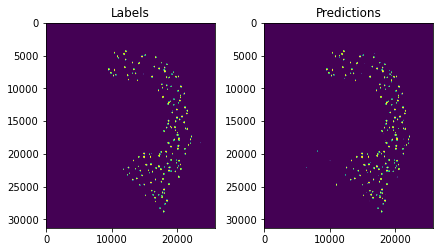

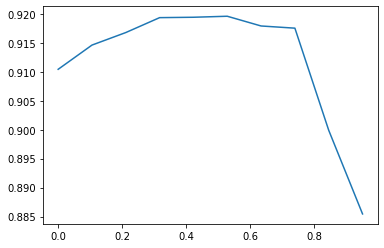

In [15]:
for fold_nb in range(8):
    model = define_model(decoder, encoder, num_classes=1, activation=None).to("cuda")
    model.load_state_dict(torch.load(f'../models/{model_name}.pt'))
    # Here use validation images to visualize fair predictions
    maskname = df_images[df_images.fold==fold_nb].tile_name.tolist()[0].split('_', 1)[0]
    print(maskname)
    predict_dataset = PredictFromImgDataset(f'../input/hubmap-kidney-segmentation/train/{maskname}.tiff',
                                            mask_name=maskname,
                                            overlap_factor=4,
                                            reduce_factor=reduce_fac,
                                            transforms=HE_preprocess(augment=False, visualize=False))

    global_pred = predict_entire_mask(predict_dataset,
                                      model,
                                      batch_size=48)
    plot_global_pred(mask=predict_dataset.mask, pred=global_pred>0)
    thresholds, scores = plot_thresh_scores(mask=predict_dataset.mask, pred=global_pred)

# Visualize some results (raw results - not averaged)

In [ ]:
model.eval()

BS = 16
val_df = df_images[df_images.fold==0].reset_index()
val_dataset = TileDataset(val_df,
                          IMG_FOLDER, MSK_FOLDER,
                          transforms=HE_preprocess(augment=False, visualize=False))

preds_dl = DataLoader(val_dataset, batch_size=BS,shuffle=True,num_workers=1)

imgs,masks = next(iter(preds_dl))

fig = plt.figure(figsize=(8,4*BS))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    raw_pred = model(img.unsqueeze(0).to('cuda'))
    pred = torch.sigmoid(raw_pred) > 0.5
    pred = pred.detach().cpu().squeeze().numpy()
    plt.subplot(BS, 2, 2*i+1)
    img = img.permute(1,2,0).numpy()#.astype(np.uint8)
    plt.imshow(img,vmin=0,vmax=255
              )
    plt.imshow(pred, alpha=0.5)
    plt.axis('off')
    plt.subplot(BS, 2 ,2*i+2)
    plt.imshow(img,vmin=0,vmax=255
              )
    plt.imshow(mask.squeeze().numpy(), alpha=0.5)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)